### Data Import and Loading 

### Loading necessary libraries

In [1]:
from numpy.random import seed
import tensorflow as tf

seed(101)
tf.random.set_seed(101)

import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras import backend as K
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input


from PIL import Image
from PIL import Image, ImageDraw

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:

IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000 # the number of images we use from each of the two classes


### What files are available? (Make sure to link histopathologic-cancer-detection dataset from Kaggle)

In [3]:
os.listdir('../input')

['vgg16-transfer-learning-pytorch',
 'vgg16',
 'histopathologic-cancer-detection']

### Labels as per csv file

0 = no tumor tissue<br>
1 =   has tumor tissue. <br>

### How many images are in each folder?

In [4]:
print(len(os.listdir('/kaggle/input/histopathologic-cancer-detection/train')))
print(len(os.listdir('/kaggle/input/histopathologic-cancer-detection/test')))

220025
57458


### Create a Dataframe containing all images

In [5]:
df_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

# Basic EDA & Data Preprocessing

In [6]:

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


### Check the class distribution

In [7]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

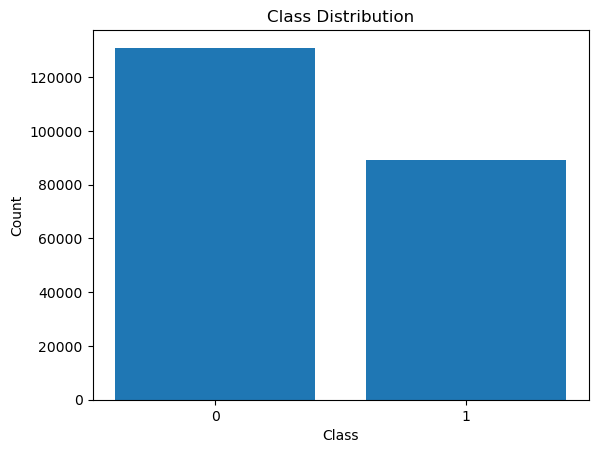

In [8]:
import matplotlib.pyplot as plt

# Calculate class counts
class_counts = df_data['label'].value_counts()

# Create a bar plot
plt.bar(class_counts.index, class_counts.values)

# Set plot labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Set x-axis tick labels
plt.xticks(class_counts.index)

# Show the plot
plt.show()


### Visualize and display a random sample of train images by class (label)

In [9]:
# inspiration from source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

# def for Visualizing Image Data by Category
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories), ncols=figure_cols, 
                         figsize=(4*figure_cols, 4*len(categories))) 

    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols)
        for j in range(0, figure_cols):
            file = IMAGE_PATH + '/' + sample.iloc[j]['id'] + '.tif'
            if os.path.isfile(file): 
                im = cv2.imread(file)
                if im is None:
                    print(f'Image file {file} could not be read')
                    continue
                ax[i, j].imshow(im, resample=True, cmap='gray')
            else:
                print(f'Image file {file} does not exist')
                
    plt.tight_layout()
    plt.show()

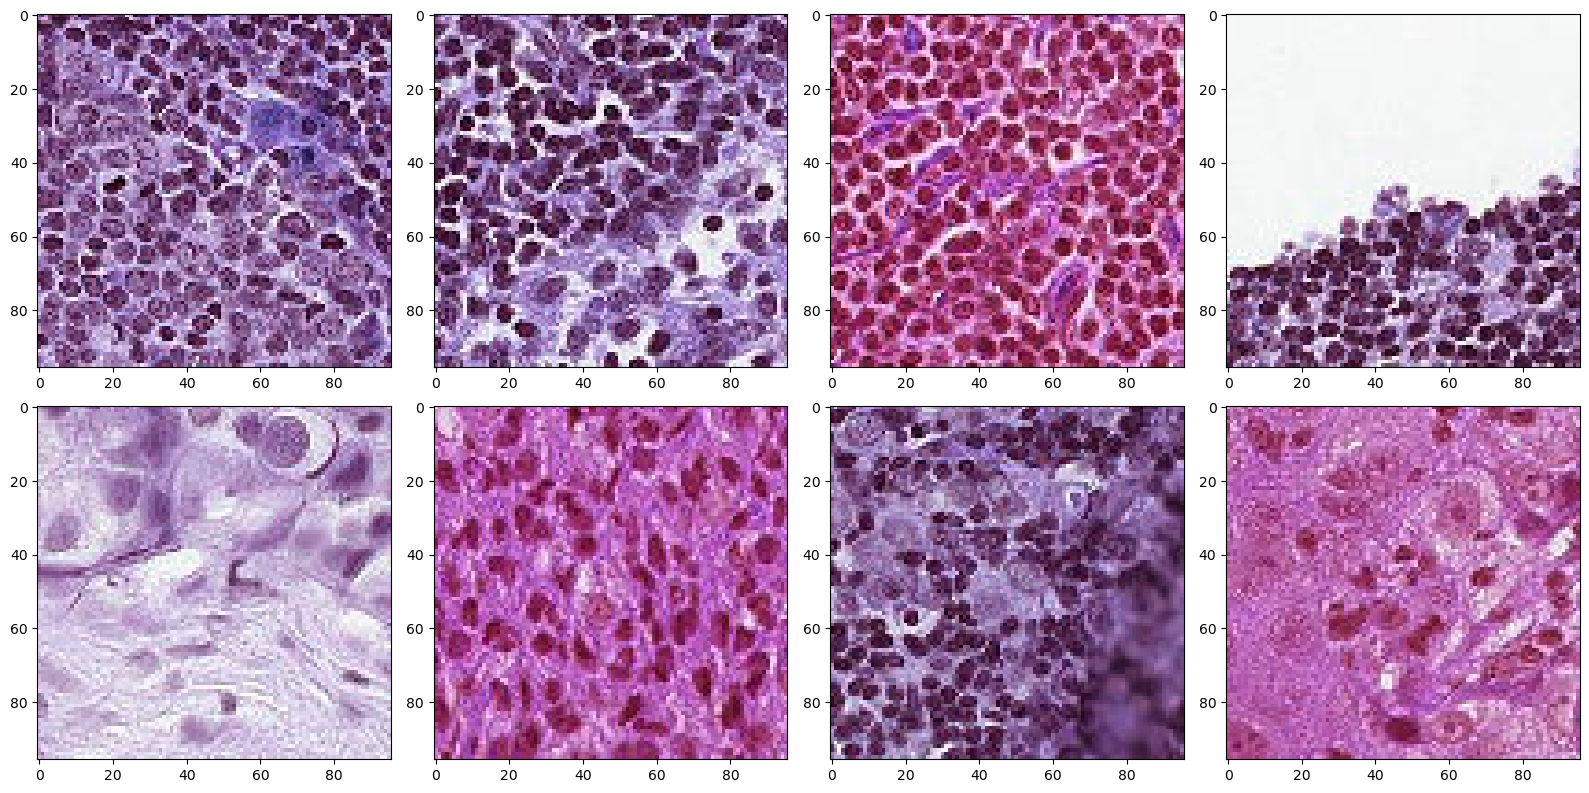

In [10]:
# Visualizing Image Data for Different Categories
IMAGE_PATH = '/kaggle/input/histopathologic-cancer-detection/train' # training data is stored in this folder

draw_category_images('label',4, df_data, IMAGE_PATH)

In [11]:
# Extracting Image IDs for Normal and Malignant Cases
malignant = df_data.loc[df_data['label']==1]['id'].values    # get the ids of malignant cases (1)
normal = df_data.loc[df_data['label']==0]['id'].values       # get the ids of the normal cases (0)

print('normal ids')
print(normal[0:3],'\n')

print('malignant ids')
print(malignant[0:3])

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [12]:
# Visualizing Image Data with Bounding Boxes
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(IMAGE_PATH ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

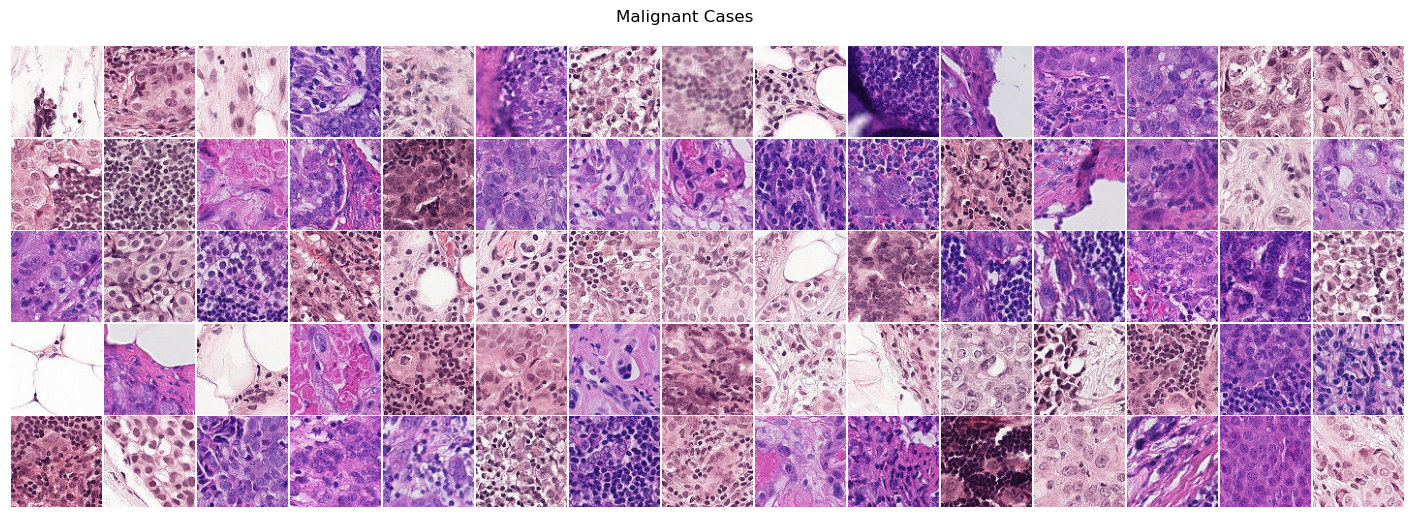

In [13]:
# Visualize label 1
plot_fig(malignant,'Malignant Cases')

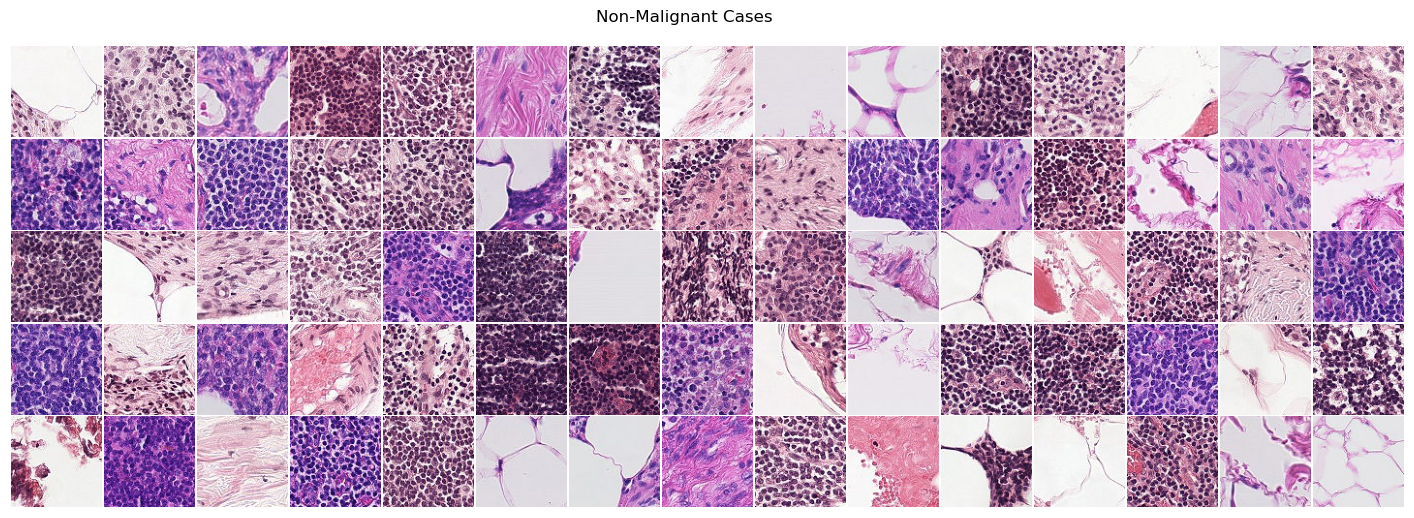

In [14]:
# Visualize label 0
plot_fig(normal,'Non-Malignant Cases')

# Data Splitting and Preparation

In [15]:
df_data.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [16]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

### Balance the target distribution
We will reduce the number of samples in class 0.

In [17]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [18]:
df_data.head()

id  label
107459  1d35e8084b7697421209c5e0463e4195f169c811      1
88068   40ae99e1ad1ad69e7e2af32372fea053b5b14c2d      1
37478   41644dee74e322fbe45eee488a617859ae520fec      0
5470    6e8a7e4c80e9ee48ec939e19af9deeee4f110ff7      0
138898  2485de6e05a78ed947d956f5fdd045bc29d924d1      1

### Create the Train and Val Sets

In [57]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(128000, 1)
(32000, 1)


In [20]:
df_train['label'].value_counts()

1    64000
0    64000
Name: label, dtype: int64

In [58]:
df_val['label'].value_counts()

1    16000
0    16000
Name: label, dtype: int64

### Create a Directory Structure

In [22]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [23]:
# check that the folders have been created
os.listdir('/kaggle/working/base_dir/train_dir')

['b_has_tumor_tissue', 'a_no_tumor_tissue']

### Transfer the images into the folders

In [61]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

KeyError: "None of ['id'] are in the columns"

In [25]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [26]:
# check how many train images we have in each folder

print(len(os.listdir('/kaggle/working/base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('/kaggle/working/base_dir/train_dir/a_no_tumor_tissue')))

64000
64000


In [27]:
# check how many val images we have in each folder

print(len(os.listdir('/kaggle/working/base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('/kaggle/working/base_dir/val_dir/b_has_tumor_tissue')))

16000
16000


# Data Modeling

### Set Up the Generators

In [28]:
train_path = '/kaggle/working/base_dir/train_dir'
valid_path = '/kaggle/working/base_dir/val_dir'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [29]:
# datagen = ImageDataGenerator(rescale=1.0/255)

# train_gen = datagen.flow_from_directory(train_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=train_batch_size,
#                                         class_mode='categorical')

# val_gen = datagen.flow_from_directory(valid_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=val_batch_size,
#                                         class_mode='categorical')

# # Note: shuffle=False causes the test dataset to not be shuffled
# test_gen = datagen.flow_from_directory(valid_path,
#                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
#                                         batch_size=1,
#                                         class_mode='categorical',
#                                         shuffle=False)



datagen_train = ImageDataGenerator(
    rescale=1.0/255,  # Data Normalization
    rotation_range=40, # Data Augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_valandtest = ImageDataGenerator(rescale=1.0/255)  # validation and test data should only be normalized, not augmented

train_gen = datagen_train.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=train_batch_size,
    class_mode='categorical'
)

val_gen = datagen_valandtest.flow_from_directory(
    valid_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=val_batch_size,
    class_mode='categorical'
)

test_gen = datagen_valandtest.flow_from_directory(
    valid_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False # Note: shuffle=False causes the test dataset to not be shuffled
)




Found 128000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.


In [30]:
# Get the labels that are associated with each index
print(train_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [31]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [32]:
# Get the labels that are associated with each index
print(test_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


### Create the Model Architecture

I've used the CNN architecture presented by @fmarazzi in this kernel:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

In [33]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.3

In [34]:
# Basic CNN model 
model_1 = Sequential()

model_1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model_1.add(BatchNormalization())
model_1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size = pool_size)) 
model_1.add(Dropout(dropout_conv))

model_1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model_1.add(BatchNormalization())
model_1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size = pool_size))
model_1.add(Dropout(dropout_conv))

model_1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size = pool_size))
model_1.add(Dropout(dropout_conv))

model_1.add(Flatten())
model_1.add(Dense(256, activation = "relu"))
model_1.add(Dropout(dropout_dense))
model_1.add(Dense(2, activation = "softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                        

In [35]:
model_1.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath = "/kaggle/working/model_1.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
callbacks_list = [checkpoint, reduce_lr]

history_1 = model_1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

# Save the trained model
model_1.save('/kaggle/working/model_1.h5')

Epoch 1/20


2023-06-22 10:39:33.286295: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4000/4000 [==============================] - 552s 135ms/step - loss: 0.4461 - accuracy: 0.8107 - val_loss: 0.4687 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 2/20
4000/4000 [==============================] - 455s 114ms/step - loss: 0.3772 - accuracy: 0.8404 - val_loss: 0.5875 - val_accuracy: 0.7426 - lr: 0.0010
Epoch 3/20
4000/4000 [==============================] - 436s 109ms/step - loss: 0.3373 - accuracy: 0.8599 - val_loss: 0.6396 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 4/20
4000/4000 [==============================] - 438s 109ms/step - loss: 0.3051 - accuracy: 0.8776 - val_loss: 0.4765 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 5/20
4000/4000 [==============================] - 439s 110ms/step - loss: 0.2903 - accuracy: 0.8845 - val_loss: 1.8760 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 6/20
4000/4000 [==============================] - 439s 110ms/step - loss: 0.2793 - accuracy: 0.8885 - val_loss: 0.4788 - val_accuracy: 0.8089 - lr: 0.0010
Epoch 7/20
4000/4000 [=======================

In [36]:
from tensorflow.keras.initializers import he_normal


In [37]:
# CNN model with guided ReLU and attention mechanism

# Create a new ReLU function
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

def squeeze_excite_block(input, ratio=16):
    ''' Create a channel-wise squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    filters = input.shape[-1]

    se = GlobalAveragePooling2D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer=he_normal(), use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer=he_normal(), use_bias=False)(se)
    se = multiply([input, se])
    return se

# Create a new model with the guided ReLU and attention mechanism
inp = Input(shape=(96, 96, 3))

x = Conv2D(first_filters, kernel_size, activation=guidedRelu)(inp)
x = squeeze_excite_block(x)
x = BatchNormalization()(x)

x = Conv2D(first_filters, kernel_size, activation=guidedRelu)(x)
x = squeeze_excite_block(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

x = Conv2D(second_filters, kernel_size, activation=guidedRelu)(x)
x = squeeze_excite_block(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

x = Conv2D(third_filters, kernel_size, activation=guidedRelu)(x)
x = squeeze_excite_block(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

x = Flatten()(x)
x = Dense(256, activation=guidedRelu)(x)
x = Dropout(dropout_dense)(x)
output = Dense(2, activation='softmax')(x)

model_2 = Model(inputs=inp, outputs=output)

model_2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 94, 94, 32)   896         ['input_1[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 32)          0           ['conv2d_5[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                                  
 reshape (Reshape)              (None, 1, 32)        0           ['global_average_pooling2d[0]

In [38]:

model_2.compile(Adam(lr=0.0015), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath = "/kaggle/working/model_2.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0015)
                                                           
callbacks_list = [checkpoint, reduce_lr]

history_2 = model_2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

# Save the trained model
model_2.save('/kaggle/working/model_2.h5')

Epoch 1/20


2023-06-22 13:16:09.235221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4000/4000 [==============================] - 468s 116ms/step - loss: 0.7053 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
4000/4000 [==============================] - 467s 117ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
4000/4000 [==============================] - 465s 116ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
4000/4000 [==============================] - 468s 117ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
4000/4000 [==============================] - 465s 116ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
4000/4000 [==============================] - 463s 116ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
4000/4000 [=======================

In [39]:
# Transfer Learning model
from keras.applications import VGG16

transfer_learning = VGG16(weights='/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(96, 96, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in transfer_learning.layers:
    layer.trainable = False

# Create a new model
model_3 = Sequential()

# Add the pre-trained VGG16 layers as the base
model_3.add(transfer_learning)

# Add additional layers on top of the VGG16 layers
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization()) 
model_3.add(Dropout(dropout_dense))
model_3.add(Dense(2, activation='softmax'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               1179904   
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                      

In [40]:
# Compile the model
model_3.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

filepath = "/kaggle/working/model_3.h5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0015)
                                                         
callbacks_list = [checkpoint, reduce_lr]

history_3 = model_3.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

# Save the trained model
model_3.save('/kaggle/working/model_3.h5')

Epoch 1/20
4000/4000 [==============================] - 450s 112ms/step - loss: 0.4339 - accuracy: 0.8019 - val_loss: 0.3933 - val_accuracy: 0.8198 - lr: 0.0010
Epoch 2/20
4000/4000 [==============================] - 440s 110ms/step - loss: 0.4157 - accuracy: 0.8101 - val_loss: 0.3721 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 3/20
4000/4000 [==============================] - 439s 110ms/step - loss: 0.4058 - accuracy: 0.8168 - val_loss: 0.3602 - val_accuracy: 0.8363 - lr: 0.0010
Epoch 4/20
4000/4000 [==============================] - 442s 111ms/step - loss: 0.4044 - accuracy: 0.8164 - val_loss: 0.3709 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 5/20
4000/4000 [==============================] - 451s 113ms/step - loss: 0.4003 - accuracy: 0.8190 - val_loss: 0.3636 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 6/20
4000/4000 [==============================] - 459s 115ms/step - loss: 0.3974 - accuracy: 0.8194 - val_loss: 0.3522 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 7/20
4000/4000 [============

### Plot the training vs validation accuracy

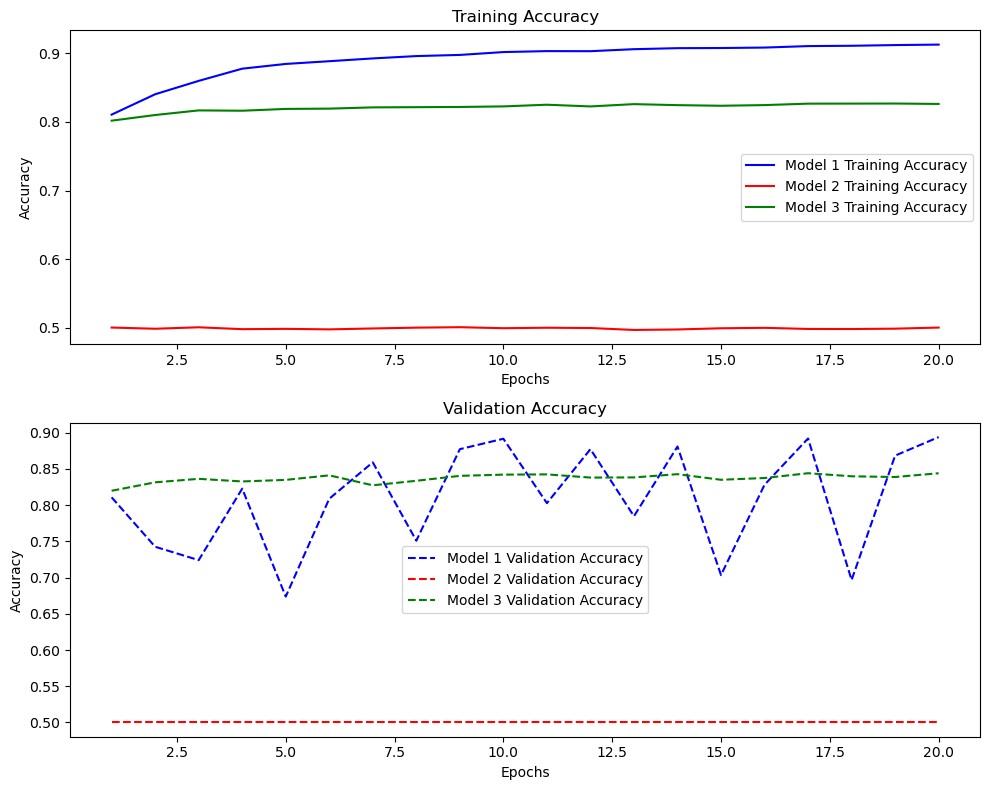

In [75]:
# Number of epochs (replace 'n' with the actual number of epochs)
n = len(history_1.history['loss'])  # assumes all models were trained for the same number of epochs
epochs = range(1, n+1)

# Get the training and validation accuracy for each model
train_acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']

train_acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

train_acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']

# Plot the training accuracy for each model
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_acc_1, 'b-', label='Model 1 Training Accuracy')
plt.plot(epochs, train_acc_2, 'r-', label='Model 2 Training Accuracy')
plt.plot(epochs, train_acc_3, 'g-', label='Model 3 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the validation accuracy for each model
plt.subplot(2, 1, 2)
plt.plot(epochs, val_acc_1, 'b--', label='Model 1 Validation Accuracy')
plt.plot(epochs, val_acc_2, 'r--', label='Model 2 Validation Accuracy')
plt.plot(epochs, val_acc_3, 'g--', label='Model 3 Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Plot the training vs validation loss

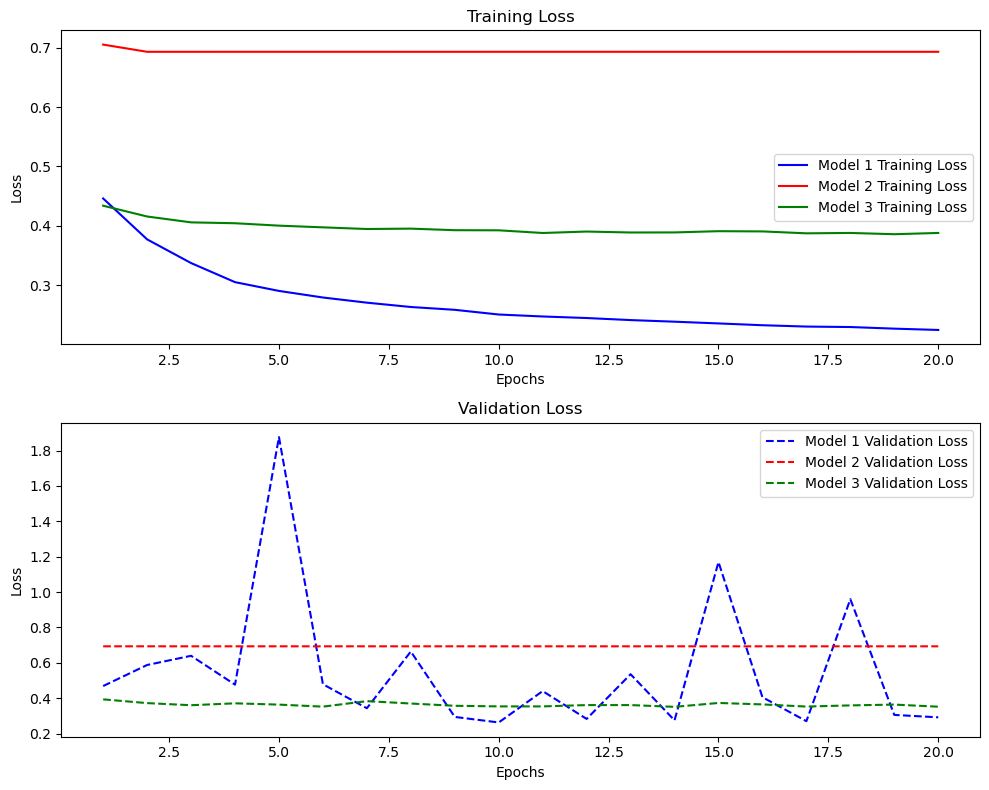

In [64]:
# Number of epochs (replace 'n' with the actual number of epochs)
n = len(history_1.history['loss'])  # assumes all models were trained for the same number of epochs
epochs = range(1, n+1)

# Get the training and validation loss for each model
train_loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

train_loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

# Plot the training loss for each model
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_1, 'b-', label='Model 1 Training Loss')
plt.plot(epochs, train_loss_2, 'r-', label='Model 2 Training Loss')
plt.plot(epochs, train_loss_3, 'g-', label='Model 3 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the validation loss for each model
plt.subplot(2, 1, 2)
plt.plot(epochs, val_loss_1, 'b--', label='Model 1 Validation Loss')
plt.plot(epochs, val_loss_2, 'r--', label='Model 2 Validation Loss')
plt.plot(epochs, val_loss_3, 'g--', label='Model 3 Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Evaluate the model using the val set

In [41]:
# get the metric names so we can use evaulate_generator
model_1.metrics_names 
model_2.metrics_names 
model_3.metrics_names 

['loss', 'accuracy']

In [66]:
df_val.head()

label
id                                             
e84342acc8ab40ab7b0fbb57c984a1abf0917a32      1
5014695ce6c74099101a50c9c52d31980b371617      1
0e682d875c11355b662139c6b0d2a93e129018d0      1
354d9e69f732428a270922dbff0a2e20e3894bc7      1
f73a73276f015a523b101b99ae126e19d1b26c6a      1

In [ ]:
# # Set the id as the index in df_data
# df_val.set_index('id', inplace=True)

In [67]:
# df_val.reset_index(inplace=True)
# df_val.head()

id  label
0  e84342acc8ab40ab7b0fbb57c984a1abf0917a32      1
1  5014695ce6c74099101a50c9c52d31980b371617      1
2  0e682d875c11355b662139c6b0d2a93e129018d0      1
3  354d9e69f732428a270922dbff0a2e20e3894bc7      1
4  f73a73276f015a523b101b99ae126e19d1b26c6a      1

In [72]:
# Load the models if they are not already in memory
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model

@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

In [74]:
# evaluate the models
model_1 = load_model('/kaggle/working/model_1.h5')
model_2 = load_model('/kaggle/working/model_2.h5', custom_objects={'guidedRelu': guidedRelu})
model_3 = load_model('/kaggle/working/model_3.h5')

# Evaluate the models
scores_1 = model_1.evaluate(val_gen, steps=val_steps, verbose=1)
scores_2 = model_2.evaluate(val_gen, steps=val_steps, verbose=1)
scores_3 = model_3.evaluate(val_gen, steps=val_steps, verbose=1)

# Print the scores
print(f"Model 1 - Loss: {round(scores_1[0], 2)}, Accuracy: {round(scores_1[1], 2)}")
print(f"Model 2 - Loss: {round(scores_2[0], 2)}, Accuracy: {round(scores_2[1], 2)}")
print(f"Model 3 - Loss: {round(scores_3[0], 2)}, Accuracy: {round(scores_3[1], 2)}")

1000/1000 [==============================] - 33s 33ms/step - loss: 0.3519 - accuracy: 0.8440
Model 1 - Loss: 0.29, Accuracy: 0.89
Model 2 - Loss: 0.69, Accuracy: 0.5
Model 3 - Loss: 0.35, Accuracy: 0.84


### Make a prediction on the val set
Model_1 is selected for prediction

We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [76]:
# make a prediction for model
predictions = model_1.predict_generator(test_gen, steps=len(df_val), verbose=1)

/tmp/ipykernel_29/1276012344.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_1.predict_generator(test_gen, steps=len(df_val), verbose=1)


32000/32000 [==============================] - 96s 3ms/step


In [77]:
predictions.shape

(32000, 2)

### A note on Keras class index values

Keras assigns it's own index value (here 0 and 1) to the classes.
It infers the classes based on the folder structure.<br>
Important: These index values may not match the index values we were given in the **train_labels.csv** file.

I've used 'a' and 'b' folder name pre-fixes to get keras to assign index values to match what
was in the train_labels.csv file - I guessed that keras is assigning the index value based on
folder name alphabetical order.

In [78]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [79]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

no_tumor_tissue  has_tumor_tissue
0         1.000000      5.466568e-10
1         0.999354      6.461152e-04
2         0.999999      6.530973e-07
3         1.000000      1.018092e-09
4         0.844314      1.556862e-01

In [80]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']


### Visualize and Display AUC Score

In [81]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9623727539062501

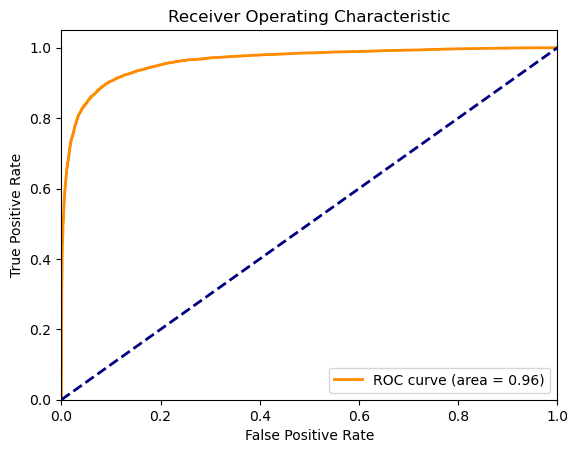

In [82]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

# put AUC visualization

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for predictions on validation set
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Create a Confusion Matrix

In [83]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [84]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [85]:
test_labels.shape

(32000,)

In [86]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [87]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

Confusion matrix, without normalization
[[15285   715]
 [ 2679 13321]]


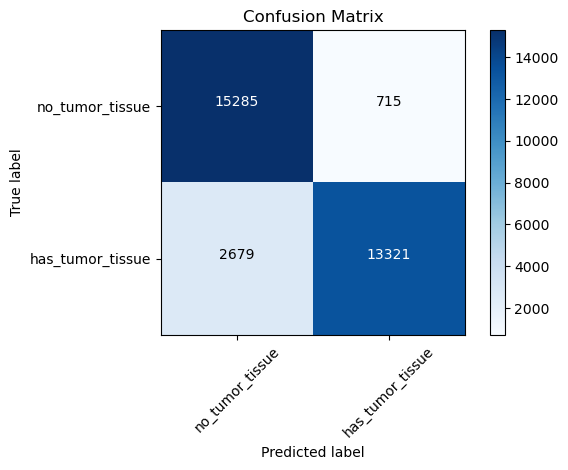

In [88]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [92]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)


                  precision    recall  f1-score   support

 no_tumor_tissue       0.85      0.96      0.90     16000
has_tumor_tissue       0.95      0.83      0.89     16000

        accuracy                           0.89     32000
       macro avg       0.90      0.89      0.89     32000
    weighted avg       0.90      0.89      0.89     32000



**Recall **= Given a class, will the classifier be able to detect it?<br>
**Precision **= Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

From the confusion matrix and classification report we see that our model is equally good at detecting both classes.

## MAKE A TEST SET PREDICTION

In [93]:
# Delete base_dir and it's sub folders to free up disk space.

shutil.rmtree('base_dir')

In [94]:

#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [95]:
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [96]:
# Transfer the test images into image_dir

test_list = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [97]:
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

### Set up the generator

In [99]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen_valandtest.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


### Make a prediction on the test images

In [100]:
num_test_images = 57458

# make sure we are using the best epoch
model_1.load_weights("/kaggle/working/model_1.h5")

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)
#Model.predict

/tmp/ipykernel_29/894025811.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)


57458/57458 [==============================] - 181s 3ms/step


In [101]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

57458

In [102]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

no_tumor_tissue  has_tumor_tissue
0         0.025402      9.745982e-01
1         0.012162      9.878383e-01
2         0.593514      4.064858e-01
3         1.000000      2.898451e-08
4         0.999965      3.455273e-05

In [103]:

# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

no_tumor_tissue  has_tumor_tissue  \
0         0.025402      9.745982e-01   
1         0.012162      9.878383e-01   
2         0.593514      4.064858e-01   
3         1.000000      2.898451e-08   
4         0.999965      3.455273e-05   

                                          file_names  
0  test_images/00006537328c33e284c973d7b39d340809...  
1  test_images/0000ec92553fda4ce39889f9226ace43ca...  
2  test_images/00024a6dee61f12f7856b0fc6be20bc7a4...  
3  test_images/000253dfaa0be9d0d100283b22284ab2f6...  
4  test_images/000270442cc15af719583a8172c87cd2bd...

In [104]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

no_tumor_tissue  has_tumor_tissue  \
0         0.025402      9.745982e-01   
1         0.012162      9.878383e-01   
2         0.593514      4.064858e-01   
3         1.000000      2.898451e-08   
4         0.999965      3.455273e-05   

                                          file_names  \
0  test_images/00006537328c33e284c973d7b39d340809...   
1  test_images/0000ec92553fda4ce39889f9226ace43ca...   
2  test_images/00024a6dee61f12f7856b0fc6be20bc7a4...   
3  test_images/000253dfaa0be9d0d100283b22284ab2f6...   
4  test_images/000270442cc15af719583a8172c87cd2bd...   

                                         id  
0  00006537328c33e284c973d7b39d340809f7271b  
1  0000ec92553fda4ce39889f9226ace43cae3364e  
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  
4  000270442cc15af719583a8172c87cd2bd9c7746

In [105]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']